# Giới thiệu phoBERT
RoBERTa là một mô hình được phát triển bởi FaceBook kế thừa các thuật toán và kiến trúc mô hình BERT. Mô hình được phá triển dựa trên framework PyTorch (cũng do FB phát triển)

Đây là một project hỗ trợ việc huấn luyện lại các model BERT trên những bộ dữ liệu mới cho các nguồn ngôn ngữ ít phổ biến. Kể từ khi ra đời, đã có rất nhiều các mô hình pretrain cho những ngôn ngữ khác nhau được huấn luyện trên RoBERTa

Với tiếng Việt, có một mô hình rất tốt được phát triển dựa trên kiến trúc RoBERTa là mô hình **PhoBERT** do VinAI phát triển.

BERT là một trong những mô hình cho kết quả SOTA (state-of-the-art) cho nhiều bài toán NLP hiện nay. Khác với những mô hình NLP trước kia, chỉ cho phép transfer learning ở mức nông, những mô hình NLP hiện đại như BERT cho phép học chuyển tiếp ở mức sâu. Vì vậy, ứng dụng mô hình BERT vào các bài toán text classification sẽ cho kết quả vượt trội

Có 2 cách như sau:
1. Sử dung phoBERT làm feature extractor, sau đó sử dụng một ML classifier để phân loại 
2. Fine-turn lại mô hình phoBERT. Tức là thêm một fully-connected layer vào cuối để làm classifier.

Trong project này. Mình sử dụng phương pháp feature extractor bằng phoBERT.



# Import thư viện cần thiết

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import time
import re
import random
import seaborn as sns
from tqdm.notebook import tqdm
import torch
import argparse
import pickle
import numpy as np
from os.path import join

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.autograd import Variable
from torch.backends import cudnn
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.manifold import TSNE
from transformers.modeling_utils import * 
from transformers import AdamW, get_linear_schedule_with_warmup, get_constant_schedule
from transformers import AutoModel, AutoTokenizer

import argparse

In [2]:
import pandas as pd 
from sklearn.model_selection import train_test_split

# Load data

Sử dụng data chưa loại bỏ stopword

In [3]:
data = pd.read_excel("../dataset/final_data1.xlsx")

In [4]:
data.isna().sum()

Rate                 0
Review               0
Label                0
Preprocess_Review    1
dtype: int64

In [5]:
data.dropna(inplace=True)

In [6]:
reviews = data["Preprocess_Review"]
labels = data["Label"]

# Chia tập Train/Test

In [7]:
train_x, test_x, train_y, test_y = train_test_split(reviews, labels, test_size=0.2, random_state=42, stratify=labels)

In [8]:
set(labels)

{-1, 0, 1}

In [9]:
set(train_y)

{-1, 0, 1}

# Sử dụng phoBERT làm feature extractor

Các bước thực hiện:

1. Tiền xử lý các câu (đã được thực hiệ trong file preprocessing_text)
2. Tokenize bàng tokenizer của phoBERT (thêm 2 token đặc biệt là CLS và SEP vào đầu và cuối câu)
3. Đưa các câu văn bản được tokenize vào model kèm theo attention mask
4. Lấy vector output đầu tiên (tại vị trí CLS) để làm đầu vào của classifier

## 1. Load model pretrained phoBERT

In [10]:
# load model phoBert và tokenizer của model đó
phoBert = AutoModel.from_pretrained('vinai/phobert-base')
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## 2. Tokenize văn bản và đưa về một kích thước cố định

In [11]:
# Đưa từng sentence qua tokenizer của PhoBERT để convert sang dạng token index với cùng chiều dài
# params
MAX_SEQ_LEN = 256 # chiều dài tối đa của một câu
# id của 1 số token đặc biệt
cls_id = 0  # đầu câu
eos_id = 2  # cuối câu
pad_id = 1  # padding

# Hàm xử lý dữ liệu trên từng sentence
def tokenize_line(line):
  tokenized = tokenizer.encode(line)
  
  l = len(tokenized)
  if l > MAX_SEQ_LEN: # nếu dài hơn thì cắt bỏ
    tokenized = tokenized[:MAX_SEQ_LEN]
    tokenized[-1] = eos_id # thêm EOS vào cuối câu
  else: # nếu ngắn hơn thì thêm padding vào
    tokenized = tokenized + [pad_id, ] * (MAX_SEQ_LEN - l)
  
  return tokenized

In [12]:
# Ví dụ
tokenized = tokenize_line('tôi khỏe')
print('After encode: ', tokenized)
print('Token size: ', len(tokenized))

After encode:  [0, 70, 3014, 15947, 1565, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Token size:  256


In [14]:
# Xử lý trên toàn tập dữ liệu
tokenized_train_x = []
tokenized_test_x = []

start = time.time()

print('Tokenizing train set ...')
for x in tqdm(train_x):
  tokenized_train_x.append(tokenize_line(x))

print('Tokenizing test set ... ')
for x in tqdm(test_x):
  tokenized_test_x.append(tokenize_line(x))

print('Done after %d seconds' %(time.time() - start))

Tokenizing train set ...


  0%|          | 0/8931 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (360 > 256). Running this sequence through the model will result in indexing errors


Tokenizing test set ... 


  0%|          | 0/2233 [00:00<?, ?it/s]

Done after 2 seconds


In [15]:
# Tạo attention mask để model chỉ tập trung vào phần nội dung mà không quan tâm tới phần padding
train_attention_mask = []
for x in tokenized_train_x:
  train_attention_mask.append(np.where(np.array(x) == 1, 0, 1))

test_attention_mask = []
for x in tokenized_test_x:
  test_attention_mask.append(np.where(np.array(x) == 1, 0, 1))

print('Done!')

Done!


In [16]:
print(train_attention_mask[10], len(train_attention_mask[10]))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 256


## 3. Đưa dữ liệu kem theo attention mash vào model phoBERT

In [17]:
# convert sang tensor
tokenized = torch.tensor(tokenized_train_x[:1]).to(torch.long)
attention_mask = torch.tensor(train_attention_mask[:1])

with torch.no_grad():
  last_hidden_states = phoBert(input_ids=tokenized, attention_mask=attention_mask)

print(last_hidden_states[0].shape)

/tmp/ipykernel_33762/2494898448.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343904639/work/torch/csrc/utils/tensor_new.cpp:245.)
  attention_mask = torch.tensor(train_attention_mask[:1])


torch.Size([1, 256, 768])


In [18]:
last_hidden_states[0]


tensor([[[-0.1909,  0.0869,  0.2894,  ...,  0.1684,  0.0599,  0.8818],
         [-0.0514, -0.1701,  0.3377,  ...,  0.6092,  0.0701,  0.0958],
         [-0.2949,  0.4445, -0.0636,  ...,  0.4426,  0.4630,  0.3305],
         ...,
         [-0.2784,  0.0824,  0.3132,  ...,  0.2925, -0.1971,  0.6939],
         [-0.2784,  0.0824,  0.3132,  ...,  0.2925, -0.1971,  0.6939],
         [-0.2784,  0.0824,  0.3132,  ...,  0.2925, -0.1971,  0.6939]]])

***Nhận xét:*** Dữ liệu trả về là một tensor có size là (1,256,768). Trong đó 1 là số sentence truyền vào, 256 là độ dài mỗi sentence và 768 là vector embedding cho mỗi word của sentence đó.

In [18]:
# Vector embedding của train set
tokenized = torch.tensor(tokenized_train_x[:100]).to(torch.long)
attention_mask = torch.tensor(train_attention_mask[:100])

start = time.time()

with torch.no_grad():
  last_hidden_states = phoBert(input_ids=tokenized, attention_mask=attention_mask)

train_features = last_hidden_states[0][:, 0, :].numpy()
print('Finish extracting features after %d seconds' %(time.time() - start))

print('Output shape: ', train_features.shape)

Finish extracting features after 23 seconds
Output shape:  (100, 768)


In [19]:
# Hàm extract feature của 1 line
def extract_line(tokenized, mask):
  tokenized = torch.tensor(tokenized).to(torch.long)
  mask = torch.tensor(mask)

  with torch.no_grad():
    last_hidden_states = phoBert(input_ids=tokenized, attention_mask=mask)
  
  feature = last_hidden_states[0][:, 0, :].numpy()

  return feature

In [20]:
document = "k ngon"

tokenized = [tokenize_line(document)]

mask = [np.where(np.array(tokenized) == 1, 0, 1)]

extract_line(tokenized, mask)

array([[ 1.45887375e-01,  4.27035362e-01, -2.68667996e-01,
        -6.65369749e-01, -9.71091762e-02, -3.94507557e-01,
         3.59896004e-01, -3.44907671e-01, -2.16611266e-01,
         2.18474761e-01, -1.73640221e-01, -3.02961260e-01,
        -3.46240844e-03,  4.33997244e-01,  6.83623016e-01,
         8.70230943e-02, -2.64169693e-01, -2.88109303e-01,
         2.90302141e-03, -4.64014858e-01,  4.41070199e-01,
        -1.27252913e+00,  6.80581748e-01, -2.86536738e-02,
         1.73290759e-01,  3.42011303e-01,  1.10351421e-01,
        -8.96911044e-03, -2.76632696e-01,  4.97710645e-01,
        -2.02433422e-01, -2.44636312e-01,  1.85745239e-01,
         1.86224565e-01,  3.79491657e-01,  5.96053675e-02,
        -4.72792350e-02, -2.38901645e-01,  1.22735567e-01,
         6.64256334e-01,  4.95662183e-01,  1.96899511e-02,
         1.62627101e-01, -6.90607846e-01, -1.83930844e-01,
        -2.72065729e-01,  3.42366070e-01,  3.81594688e-01,
        -1.00714356e-01,  4.04931784e-01, -1.15193844e-0

In [21]:
# Embed tập train
train_size = len(tokenized_train_x)
EMBED_SIZE = 768
train_features = np.zeros(shape=(train_size, EMBED_SIZE))

start = time.time()

step = 20
for i in tqdm(range(0, train_size, step)):
  mask = train_attention_mask[i:i+step]
  tokenized = tokenized_train_x[i:i+step]
  feature = extract_line(tokenized, mask)
  train_features[i:i+step] = feature

print('Finish extracting features after %d seconds' %(time.time() - start))
print('Output shape: ', train_features.shape)

  0%|          | 0/447 [00:00<?, ?it/s]

Finish extracting features after 2352 seconds
Output shape:  (8931, 768)


In [22]:
# Thực hiện tương tự trên tập test
test_size = len(tokenized_test_x)
EMBED_SIZE = 768
test_features = np.zeros(shape=(test_size, EMBED_SIZE))

start = time.time()

step = 20
for i in tqdm(range(0, test_size, step)):
  mask = test_attention_mask[i:i+step]
  tokenized = tokenized_test_x[i:i+step]
  feature = extract_line(tokenized, mask)
  test_features[i:i+step] = feature

print('Finish extracting features after %d seconds' %(time.time() - start))
print('Output shape: ', test_features.shape)

  0%|          | 0/112 [00:00<?, ?it/s]

Finish extracting features after 525 seconds
Output shape:  (2233, 768)


In [20]:
import os
import pickle

# xác định đường dẫn tới thư mục hiện tại
current_dir = os.path.dirname(os.path.abspath("4. phoBERT.ipynb"))

# đường dẫn tới file cần lưu
bert_features_path = os.path.join(current_dir, 'bert_features.sav')
bert_test_features_path = os.path.join(current_dir, 'bert_test_features.sav')



In [25]:
# lưu danh sách embed train
pickle.dump(train_features, open(bert_features_path, 'wb'))

In [26]:
# lưu danh sách embed test
pickle.dump(test_features, open(bert_test_features_path, 'wb'))

# Train classifier bằng feature thu thập được 

In [21]:
# load vector embedding đã lưu
train_features = pickle.load(open(bert_features_path, 'rb'))
test_features = pickle.load(open(bert_test_features_path, 'rb'))

In [22]:
import seaborn as sb
def display_result(model):
  print(classification_report(test_y, y_pred))
  plt.figure(figsize=(5, 3))
  conf_matrix = confusion_matrix(test_y, y_pred, labels=labels.unique())
  sb.heatmap(conf_matrix, annot=True, fmt='g', cmap='YlOrRd')

## Logistic regression

In [23]:
logisticReg = LogisticRegression(max_iter=100_000)

start = time.time()
logisticReg.fit(train_features, train_y)

print('Logistic Regression finish training after %d second' %(time.time() - start))

bert_logreg_path = './bert_logreg.sav'
pickle.dump(logisticReg, open(bert_logreg_path, 'wb'))

Logistic Regression finish training after 6 second


In [24]:
# Đánh giá độ chính xác của mô hình Logistic Regression
y_pred = logisticReg.predict(test_features)

acc = np.mean(y_pred == np.array(test_y))

print('Accuracy: ', acc)

Accuracy:  0.8056426332288401


              precision    recall  f1-score   support

          -1       0.76      0.81      0.79       656
           0       0.32      0.20      0.25       232
           1       0.88      0.91      0.89      1345

    accuracy                           0.81      2233
   macro avg       0.65      0.64      0.64      2233
weighted avg       0.79      0.81      0.79      2233



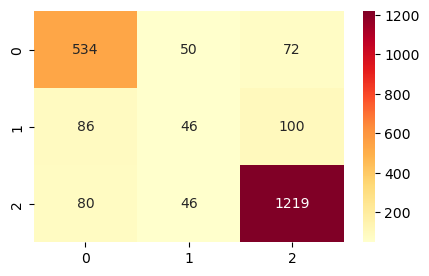

In [25]:
display_result(logisticReg)

## SVM

In [21]:
svm = SVC()

start = time.time()
svm.fit(train_features, train_y)
print('SVM classifier finish training after %d seconds' %(time.time() - start))

bert_svm_path = './bert_svm.sav'
pickle.dump(svm, open(bert_svm_path, 'wb'))

SVM classifier finish training after 18 seconds


In [22]:
# Đánh giá độ chính xác
y_pred = svm.predict(test_features)

acc = np.mean(y_pred == np.array(test_y))
print('Accuracy: ', acc)

Accuracy:  0.8284818629646216


              precision    recall  f1-score   support

          -1       0.79      0.85      0.82       656
           0       0.53      0.04      0.07       232
           1       0.85      0.96      0.90      1345

    accuracy                           0.83      2233
   macro avg       0.72      0.61      0.60      2233
weighted avg       0.80      0.83      0.79      2233



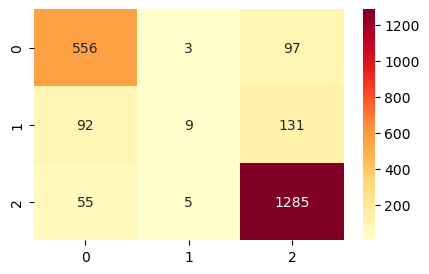

In [23]:
display_result(svm)

# KNN

In [24]:
from sklearn.neighbors import KNeighborsClassifier

In [25]:
KNN = KNeighborsClassifier()

start = time.time()
KNN.fit(train_features, train_y)
print('KNN classifier finish training after %d seconds' %(time.time() - start))

KNN classifier finish training after 0 seconds


In [26]:
# Đánh giá độ chính xác của mô hình KNN
y_pred = KNN.predict(test_features)

acc = np.mean(y_pred == np.array(test_y))

print('Accuracy: ', acc)

Accuracy:  0.7380206000895656


              precision    recall  f1-score   support

          -1       0.70      0.71      0.71       656
           0       0.19      0.11      0.14       232
           1       0.81      0.86      0.83      1345

    accuracy                           0.74      2233
   macro avg       0.57      0.56      0.56      2233
weighted avg       0.71      0.74      0.72      2233



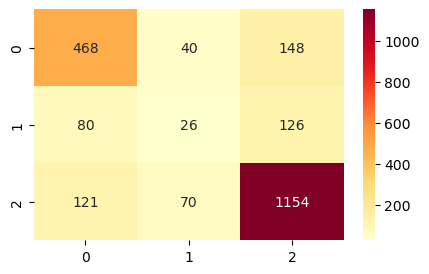

In [28]:
display_result(KNN)


## Decission Tree

In [29]:
from sklearn import tree

In [30]:
DTree = tree.DecisionTreeClassifier()
start = time.time()
DTree.fit(train_features, train_y)
print('DTree classifier finish training after %d seconds' %(time.time() - start))

DTree classifier finish training after 15 seconds


In [31]:
# Đánh giá độ chính xác của mô hình MNB
y_pred = DTree.predict(test_features)

acc = np.mean(y_pred == np.array(test_y))

print('Accuracy: ', acc)

Accuracy:  0.6023287057769816


              precision    recall  f1-score   support

          -1       0.54      0.52      0.53       656
           0       0.14      0.19      0.16       232
           1       0.74      0.72      0.73      1345

    accuracy                           0.60      2233
   macro avg       0.47      0.47      0.47      2233
weighted avg       0.62      0.60      0.61      2233



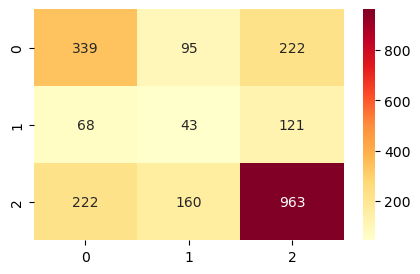

In [32]:
display_result(DTree)

## Random forest

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
rf = RandomForestClassifier()
start = time.time()
rf.fit(train_features, train_y)
print('Random forest classifier finish training after %d seconds' %(time.time() - start))

Random forest classifier finish training after 25 seconds


In [35]:
# Đánh giá độ chính xác của mô hình MNB
y_pred = rf.predict(test_features)

acc = np.mean(y_pred == np.array(test_y))

print('Accuracy: ', acc)

Accuracy:  0.7559337214509628


              precision    recall  f1-score   support

          -1       0.80      0.61      0.69       656
           0       0.00      0.00      0.00       232
           1       0.74      0.96      0.84      1345

    accuracy                           0.76      2233
   macro avg       0.51      0.52      0.51      2233
weighted avg       0.68      0.76      0.71      2233



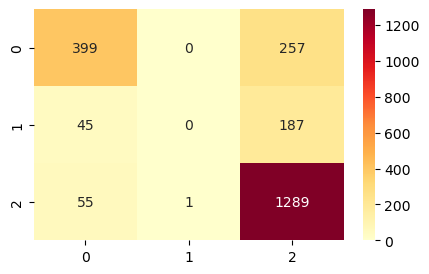

In [36]:
display_result(rf)


# Tổng kết và nhận xét

|<center><div style="width:150px"></div><center>|<center><div style="width:290px">Macro avg F1-score </div><center>|<center><div style="width:290px">Weighted avg F1-score </div><center>|
|---------- |:-------------:|:-------------:|
|KNN|<center>0.56<center>|<center>0.72<center>|
|Logistic Regression|<center>0.64<center> |<center>0.79<center>|
|SVM| <center>0.60<center> |<center>0.79<center>|
|Decision Tree| <center>0.47<center> |<center>0.61<center>|
|Random Forest| <center>0.51<center> |<center>0.71<center>|


Kết quả cho thấy: Thuật toán logistic regression cho kết quả tốt nhất

# Tinh chỉnh tham số bằng gridsearch

In [26]:
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate, GridSearchCV, cross_val_score

In [27]:
# Define parameter grid
# param_grid = {'C': np.arange(0.25,7.5,0.25),
#               'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
#               }
param_grid = {'C': np.arange(0.25,7.5,0.25)}


# Define grid search
grid_search = GridSearchCV(logisticReg, param_grid, cv=5, n_jobs=-1)

# Train the model with grid search
start = time.time()
grid_search.fit(train_features, train_y)
print('Searching time:', (time.time() - start))

# Print the best parameters
print('Best parameters:', grid_search.best_params_)

Searching time: 790.2389500141144
Best parameters: {'C': 0.25}


## Best model 

In [28]:
best_model = LogisticRegression(C= 0.25, solver='liblinear')
start = time.time()
best_model.fit(train_features, train_y)
print('Logistic training time: %d' %(time.time() - start))

Logistic training time: 6


In [29]:
# Đánh giá độ chính xác của mô hình best
y_pred = best_model.predict(test_features)

acc = np.mean(y_pred == np.array(test_y))

print('Accuracy: ', acc)

Accuracy:  0.8266905508284819


              precision    recall  f1-score   support

          -1       0.78      0.85      0.81       656
           0       0.43      0.15      0.22       232
           1       0.87      0.93      0.90      1345

    accuracy                           0.83      2233
   macro avg       0.69      0.64      0.64      2233
weighted avg       0.80      0.83      0.80      2233



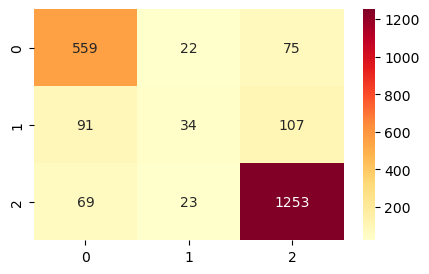

In [30]:
display_result(best_model)

## Export model 

In [31]:
import joblib

joblib.dump(best_model, "clf_logic.pkl")

['clf_logic.pkl']